# Airbnb data insight for Boston and Seattle area

## Business Understanding

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.

Airbnb is currently a very popular platform for both guests and hosts to enjoy their customized travellings. There are many interesting things we can explore using the data from Airbnb insight. Let's get started by using the data of Boston and Seattle cities.

Three interesting questions come to my mind when looking into the data:

1. Is there any difference in price between Boston and Seattle area?
2. Can we predict price in Boston and Seattle Airbnb using this dataset?
3. What's the top important features when predicting the price in two cities?

## Load the data first:

In [273]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import mplleaflet
from tqdm import tqdm
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
boston_listings = pd.read_csv('../data/boston/listings.csv')
seattle_listings = pd.read_csv('../data/seattle/listings.csv')

In [3]:
boston_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [4]:
seattle_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [5]:
boston_listings.shape

(3585, 95)

In [6]:
seattle_listings.shape

(3818, 92)

In [7]:
boston_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [8]:
seattle_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

## Visualize airbnb location in Boston and Seattle area

Dataset from both Boston and Seattle contains geographical information. Let's draw their geospatial distribution in map to take a look.

In [10]:
boston_samples = boston_listings.sample(100)
plt.scatter(boston_samples['longitude'], boston_samples['latitude'])
mplleaflet.display()

In [11]:
seattle_samples = seattle_listings.sample(100)
plt.scatter(seattle_samples['longitude'], seattle_samples['latitude'])
mplleaflet.display()

As our expectation, most rents locate at downtown area, where travellers can find more fun :)). Let's try to solve the three questions above then.

## Is there any difference in price?

In [12]:
boston_prices = pd.read_csv('../data/boston/calendar.csv').dropna(how = 'any', axis = 0)
seattle_prices = pd.read_csv('../data/seattle/calendar.csv').dropna(how = 'any', axis = 0)

In [13]:
seattle_prices.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
9,241032,2016-01-13,t,$85.00
10,241032,2016-01-14,t,$85.00
14,241032,2016-01-18,t,$85.00


In [242]:
seattle_prices

,id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0
15,241032,2016-01-19,t,85.0
16,241032,2016-01-20,t,85.0
20,241032,2016-01-24,t,85.0
21,241032,2016-01-25,t,85.0
22,241032,2016-01-26,t,85.0


In [243]:
seattle_prices.shape

(934542, 4)

In [14]:
boston_prices['price'] = boston_prices['price'].apply(lambda x : float(x.replace('$', '').replace(',', '')))
seattle_prices['price'] = seattle_prices['price'].apply(lambda x : float(x.replace('$', '').replace(',', '')))

In [15]:
boston_prices['price'].describe()

count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: price, dtype: float64

In [340]:
max(boston_prices['price'])

7163.0

In [16]:
seattle_prices['price'].describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

## Two distribution t-test with different variance assumption

$$H_0 : \bar{X_1}\ =\ \bar{X_2}  \\ H_1 : \bar{X_1}\ !=\ \bar{X_2}$$


$$t = \frac{\bar{X_1} - \bar{X_2}}{s}\enspace$$  satisfies t-distribution where 
$$\enspace s = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$


Degree of freedom is equal to
$$
DF = \frac{(VAR_1 + VAR_2)^2}{\frac{VAR_1^2}{n_1 - 1} + \frac{VAR_2^2}{n_2 - 1}} 
$$

After testing, we find that the p-value is smaller than 0.001, which means that we should reject $H_0$ with a high confidence. And the average renting price between Boston and Seattle is very different.

In [52]:
s_2 = np.sqrt(seattle_prices['price'].std()**2 / seattle_prices['price'].shape[0] + \
              boston_prices['price'].std()**2 / boston_prices['price'].shape[0])

t = (seattle_prices['price'].mean() - boston_prices['price'].mean()) / s_2

In [53]:
t

-242.40846787381446

In [65]:
seattle_prices['price'].var()

11038.206657946257

In [66]:
DF = (seattle_prices['price'].var() + boston_prices['price'].var())**2 / \
     (seattle_prices['price'].var()**2 / (seattle_prices['price'].shape[0] - 1) + \
      boston_prices['price'].var()**2 / (boston_prices['price'].shape[0] - 1))
DF

1069725.0833099699

According to the t-test table, we find that the mean value for prices in Boston and Seattle is different. With p-value < 0.001

## Price value histogram for Boston and Seattle cities

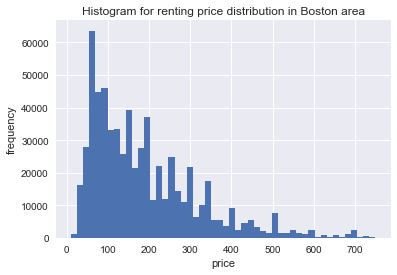

In [344]:
plt.hist(list(boston_prices[boston_prices['price'] < 5 * np.median(boston_prices['price'])]['price']), bins = 50)
#plt.hist(list(boston_prices[boston_prices['price'] < np.mean(boston_prices['price']) + \
#                                                     5 * np.std(boston_prices['price'])]['price']), bins = 50)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Histogram for renting price distribution in Boston area')
plt.show()

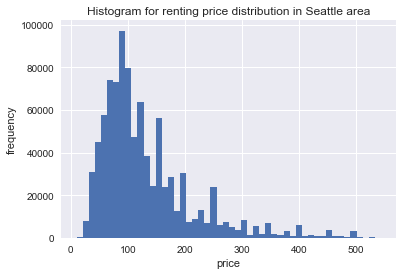

In [342]:
plt.hist(list(seattle_prices[seattle_prices['price'] < 5 * np.median(seattle_prices['price'])]['price']), bins = 50)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Histogram for renting price distribution in Seattle area')
plt.show()

## Make prediction towards price in two cities

In [74]:
boston_prices = boston_prices.rename(columns = {'listing_id' : 'id'})
seattle_prices = seattle_prices.rename(columns = {'listing_id' : 'id'})


In [97]:
boston_df = pd.merge(boston_listings, boston_prices, on = 'id')
seattle_df = pd.merge(seattle_listings, seattle_prices, on = 'id')

In [100]:
boston_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [113]:
b_columns = [col for col in boston_df.columns if boston_df[col].dtype == 'float64' or boston_df[col].dtype == 'int64']
s_columns = [col for col in seattle_df.columns if seattle_df[col].dtype == 'float64' or seattle_df[col].dtype == 'int64']

In [247]:
boston_numeric = boston_df[b_columns]
seattle_numeric = seattle_df[s_columns]

### Drop features with all null value

In [127]:
seattle_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month', 'price_y'],
      dtype='object')

In [128]:
boston_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month', 'price_y'],
      dtype='object')

In [248]:
boston_numeric = boston_numeric.drop(columns = boston_numeric.columns[boston_numeric.isnull().all()])
seattle_numeric = seattle_numeric.drop(columns = seattle_numeric.columns[seattle_numeric.isnull().all()])

In [137]:
boston_numeric.columns[boston_numeric.isnull().any()]

Index(['bathrooms', 'bedrooms', 'beds', 'square_feet', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [139]:
boston_numeric[boston_numeric['bathrooms'].isnull()]

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,price_y
22141,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22142,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22143,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22144,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22145,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22146,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22147,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22148,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22149,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0
22150,777903,20160906204935,4102281,1,1,42.307574,-71.134630,2,NaN,1.0,...,94.0,10.0,9.0,10.0,10.0,10.0,10.0,1,0.43,85.0


### fill na with median of columns

In [249]:
fill_median = lambda col : col.fillna(col.median())
boston_numeric = boston_numeric.apply(fill_median, axis = 0)
seattle_numeric = seattle_numeric.apply(fill_median, axis = 0)

In [143]:
boston_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'price_y'],
      dtype='object')

In [144]:
seattle_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'price_y'],
      dtype='object')

### Filter useless features

In [250]:
boston_numeric = boston_numeric.drop(columns=['scrape_id', 'host_id'])
seattle_numeric = seattle_numeric.drop(columns=['scrape_id', 'host_id'])

# price prediction with xgboost

In [259]:
def train_test_id(id_lst, test_portion = 0.25):
    """
        Randomly split training and test id.
        Input: 
            id_lst is the list of all ids
        return:
            train_id_list, test_id_list
    """
    id_lst = list(id_lst)
    cnt = 0
    size = len(id_lst)
    test_lst = []
    while True:
        pos = int(np.floor(np.random.rand() * len(id_lst)))
        test_lst.append(id_lst.pop(pos))
        cnt += 1
        if len(test_lst) >= test_portion * size:
            break
    return id_lst, test_lst
    

In [155]:
X_boston, y_boston = boston_numeric.loc[:,boston_numeric.columns != 'price_y'], boston_numeric['price_y']
X_seattle, y_seattle = seattle_numeric.loc[:,seattle_numeric.columns != 'price_y'], seattle_numeric['price_y']


In [184]:
def search_params(params, estimator, X, y, cv = 5):
    clf = GridSearchCV(estimator, params, cv = cv, scoring = 'neg_mean_squared_error', verbose = 2)
    clf.fit(X, y)
    return clf.best_params_

def cal_rmse(y_pred, y_true):
    return np.sqrt(np.sum((y_pred - y_true)**2 / len(y_pred)))
    

## Boston price prediction:

In [268]:
boston_numeric.head()

,id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,price_y
0,3075044,1,1,42.286241,-71.134374,2,1.0,1.0,1.0,800.0,...,94.0,10.0,9.0,10.0,10.0,9.0,9.0,1,1.3,65.0
1,3075044,1,1,42.286241,-71.134374,2,1.0,1.0,1.0,800.0,...,94.0,10.0,9.0,10.0,10.0,9.0,9.0,1,1.3,65.0
2,3075044,1,1,42.286241,-71.134374,2,1.0,1.0,1.0,800.0,...,94.0,10.0,9.0,10.0,10.0,9.0,9.0,1,1.3,65.0
3,3075044,1,1,42.286241,-71.134374,2,1.0,1.0,1.0,800.0,...,94.0,10.0,9.0,10.0,10.0,9.0,9.0,1,1.3,75.0
4,3075044,1,1,42.286241,-71.134374,2,1.0,1.0,1.0,800.0,...,94.0,10.0,9.0,10.0,10.0,9.0,9.0,1,1.3,75.0


In [278]:
train_id, test_id = train_test_id(boston_numeric['id'].unique())
train_entries = list(tqdm(map(lambda x : x in train_id, boston_numeric['id'])))
test_entries = list(tqdm(map(lambda x : x in test_id, boston_numeric['id'])))

X_train, X_test, y_train, y_test = X_boston[train_entries], X_boston[test_entries], \
                                   y_boston[train_entries], y_boston[test_entries]

643037it [01:43, 6239.07it/s] 
643037it [00:48, 13302.79it/s]


In [291]:
X_train.columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [339]:
params = {'max_depth' : [5, 7, 10],
          'learning_rate' : [0.1],
          'n_estimators' : [200]}

xgb = XGBRegressor(booster='gbtree', n_jobs=2)
boston_opt_params = search_params(params, xgb, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  57.8s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.5s remaining:    0.0s


[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  59.9s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  58.9s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  57.9s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  57.7s
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=7, total= 1.4min
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=7, total= 1.4min
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=7, total= 1.4min
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 22.4min finished


In [293]:
xgb_boston = XGBRegressor(booster='gbtree', **boston_opt_params)
xgb_boston.fit(X_train, y_train, eval_metric = 'rmse')
y_pred = xgb_boston.predict(X_test)

In [296]:
y_test

1877      58.0
1878      58.0
1879      58.0
1880      58.0
1881      58.0
1882      58.0
1883      58.0
1884      58.0
1885      58.0
1886      58.0
1887      58.0
1888      58.0
1889      58.0
1890      58.0
1891      58.0
1892      58.0
1893      58.0
1894      58.0
1895      58.0
1896      58.0
1897      58.0
1898      58.0
1899      58.0
1900      58.0
1901      58.0
1902      58.0
1903      58.0
1904      58.0
1905      58.0
1906      58.0
          ... 
641016    68.0
641017    68.0
641018    68.0
641019    68.0
641020    68.0
641021    68.0
641022    68.0
641023    68.0
641024    68.0
641025    68.0
641026    68.0
641027    68.0
641028    68.0
641029    68.0
641030    68.0
641031    68.0
641032    68.0
641033    68.0
641034    68.0
641035    68.0
641036    68.0
641037    68.0
641038    68.0
641039    68.0
641040    68.0
641041    68.0
641042    68.0
641043    68.0
641044    68.0
641045    68.0
Name: price_y, Length: 155778, dtype: float64

In [294]:
print(cal_rmse(y_pred, y_test))

118.66261819599998


In [331]:
def visualize_pred(y_pred, y_test, city = 'Boston'):
    vis_lst = [i for i in range(len(y_pred))]
    np.random.shuffle(vis_lst)
    y_test = y_test.reset_index()

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set(xlabel='Samples', ylabel='prices',
           title='Predicted and true price comparison for Airbnb in ' + city +' area(100 samples)')
    ax.plot(range(len(y_pred[vis_lst[:100]])),y_pred[vis_lst[:100]], color = 'blue')
    ax.plot(range(len(y_test.loc[vis_lst[:100], 'price_y'])),y_test.loc[vis_lst[:100], 'price_y'], color = 'red')
    ax.legend(('predicted price', 'true price'),
               loc='upper right')
    plt.show() 

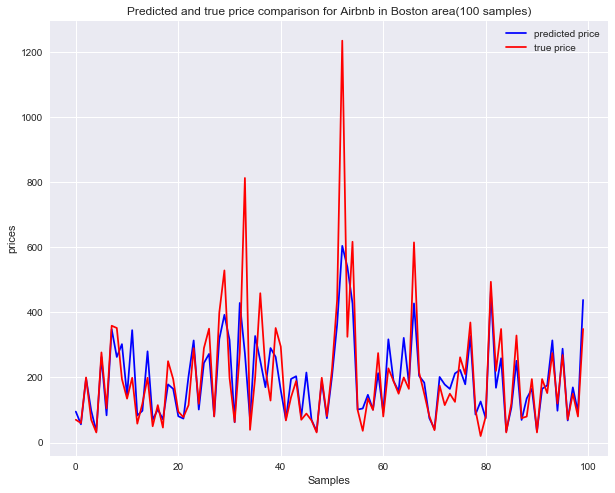

In [335]:
visualize_pred(y_pred, y_test)

In [329]:
y_test.reset_index().loc[vis_lst[:100]]

,index,price_y
98940,408052,399.0
115961,472755,65.0
141432,576953,126.0
128773,524954,55.0
1115,6617,200.0
97990,403006,165.0
148222,604363,69.0
57951,234729,382.0
91526,371496,608.0
2834,17136,70.0


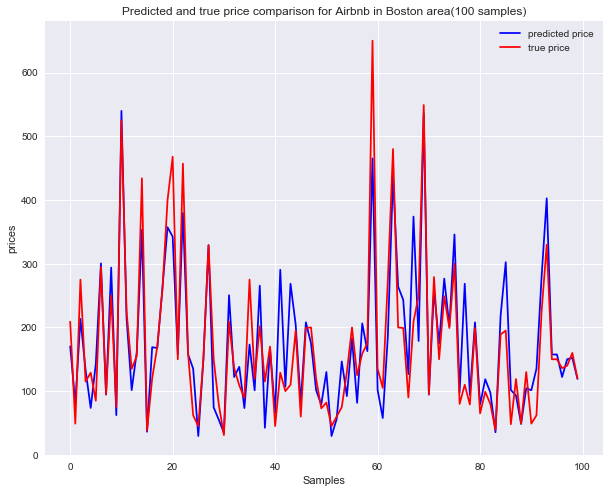

In [354]:
vis_lst = [i for i in range(len(y_pred))]
np.random.shuffle(vis_lst)
#y_test = y_test.reset_index()

fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlabel='Samples', ylabel='prices',
       title='Predicted and true price comparison for Airbnb in ' + 'Boston' +' area(100 samples)')
ax.plot(range(len(y_pred[vis_lst[:100]])),y_pred[vis_lst[:100]], color = 'blue')
ax.plot(range(len(y_test.loc[vis_lst[:100], 'price_y'])),y_test.loc[vis_lst[:100], 'price_y'], color = 'red')
ax.legend(('predicted price', 'true price'),
           loc='upper right')
plt.show() 

## Seattle price prediction:

In [191]:
X_seattle, y_seattle = seattle_numeric.loc[:,seattle_numeric.columns != 'price_y'], seattle_numeric['price_y']

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X_seattle, y_seattle)
params = {'max_depth' : [5],
          'learning_rate' : [0.1],
          'n_estimators' : [100, 200]}

xgb = XGBRegressor(booster='gbtree', n_jobs=2)
seattle_opt_params = search_params(params, xgb, X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  54.0s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.7s remaining:    0.0s


[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  54.5s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  55.3s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  52.3s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  52.2s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total= 1.8min
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total= 1.7min
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total= 1.7min
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 13.4min finished


In [200]:
xgb_seattle = XGBRegressor(booster='gbtree', **seattle_opt_params)
xgb_seattle.fit(X_train, y_train, eval_metric = 'rmse')
y_pred_seattle = xgb_seattle.predict(X_test)
print(cal_rmse(y_pred_seattle, y_test))

36.855132499376325


In [202]:
seattle_opt_params

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

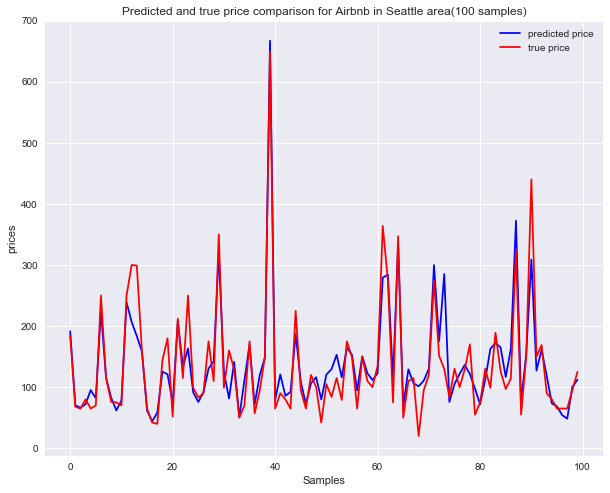

In [201]:
visualize_pred(y_pred_seattle, y_test, 'Seattle')

# Top important features for price prediction

In [223]:
def visualize_feature(features, feat_importance, city = 'Boston'):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set(xlabel='feature name', ylabel='feature importance',
           title='feature importance level for ' + city + ' city')
    ax.bar(features, feat_importance)
    plt.xticks(features, rotation='vertical')
    plt.show() 

### Boston city

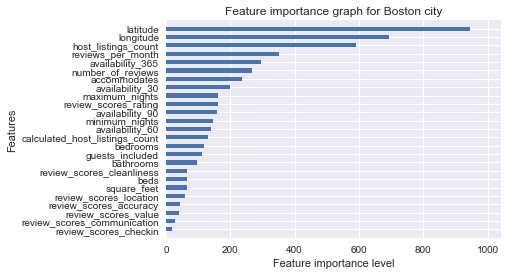

In [234]:
plot_importance(xgb_boston, height=0.5, show_values=False, xlabel='Feature importance level', \
                title='Feature importance graph for Boston city')
plt.show()

### Seattle city

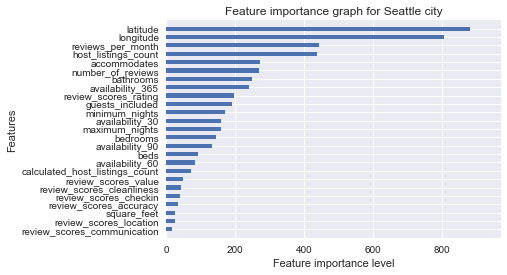

In [239]:
plot_importance(xgb_seattle, height=0.5, show_values=False, xlabel='Feature importance level', \
                title='Feature importance graph for Seattle city')
plt.show()